# LangGraph Components

In [17]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults

In [18]:
import os
os.environ["TAVILY_API_KEY"] = "None"
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [19]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [20]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_model)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_model(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [21]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
model = ChatOllama(model = "qwen2.5:7b")
abot = Agent(model, [tool], system=prompt)

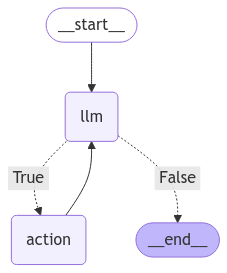

In [22]:
from IPython.display import Image, display
try:
  display(Image(abot.graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [23]:
messages = [HumanMessage(content="What is the stock price of Maybank")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Maybank stock price'}, 'id': '8a00e730-96ac-481d-9854-eab83217c15d', 'type': 'tool_call'}
Back to the model!


In [24]:
result

{'messages': [HumanMessage(content='What is the stock price of Maybank', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-01-25T14:07:33.521024Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'Maybank stock price'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1279856300, 'load_duration': 69014000, 'prompt_eval_count': 244, 'prompt_eval_duration': 11000000, 'eval_count': 27, 'eval_duration': 1190000000}, id='run-dd9ddd92-dcb3-4c62-8260-46386282cae0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Maybank stock price'}, 'id': '8a00e730-96ac-481d-9854-eab83217c15d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 244, 'output_tokens': 27, 'total_tokens': 271}),
  ToolMessage(content='[{\'url\': \'https://www.google.com/finance/quote/MAYBANK:KLSE\', 

In [25]:
print(result['messages'][-1].content)

The stock price of Maybank (Malayan Banking Bhd) can be checked on financial platforms like Google Finance. According to the information available, as of the latest update, Maybank's stock is trading at RM 4.46.

For real-time updates and more detailed analysis, you might want to visit:
- [Google Finance](https://www.google.com/finance/quote/MAYBANK:KLSE)
- [TradingView](https://www.tradingview.com/symbols/MYX-MAYBANK/)
- [I3investor](https://klse.i3investor.com/web/stock/overview/1155) 

These platforms offer current stock prices, charts, news, and detailed financial information.


In [26]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco and Los Angeles'}, 'id': '17fb87c2-81bc-4031-bd4a-f3999c9c432d', 'type': 'tool_call'}
Back to the model!


In [29]:
print(result['messages'][-1].content)

It seems there was a mix-up with the location in the search result. Let me clarify:

- For Los Angeles: 
The current temperature is around 64.6°F (18.1°C) with partly cloudy skies.

- For San Francisco:
In January 2025, the average temperature is expected to be around 13°F (-10.5°C), and it will experience heavy rainfall with over 20 rainy days. The forecast for New Year's Day suggests temperatures in the low 40s to mid-50s Fahrenheit.

The information provided might not be entirely accurate or up-to-date due to some discrepancies, so I recommend checking a reliable weather source for the most current conditions.


In [ ]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_aIEeqWpIRudtjPoTuWpuM1T5', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_kj1qqb9j6AQYCLlUSor6zmSx', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_rjTzc0R8PmoSAUAMMICld0sj', 'type': 'tool_call'}
Back to the model!


In [34]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. The GDP of Missouri in 2024 was approximately $349 billion.
